In [1]:
import nashpy as nash
import numpy as np
import random
from ipycanvas import MultiCanvas, hold_canvas
from IPython.display import display
import time
import copy
from ipypb import irange
import matplotlib.pyplot as plt

In [5]:
class TwoPlayerGridWordGame:
    ((0, 0), (0, 1)), ((2, 0), (2, 1))

    def __init__(
        self, dim=(3, 3), goal=(1, 0), semi_walls=[((0, 1), (0, 2)), ((2, 1), (2, 2))]
    ):
        self._dim = dim
        self._goal = goal
        self._semi_walls = set(semi_walls + [(w[1], w[0]) for w in semi_walls])
        self.state = None

    def setup_canvas(self):
        self._cell_size = 64
        self._line_width = 2
        self._canvas = MultiCanvas(
            3,
            size=(
                self._line_width + self._cell_size * self._dim[0],
                self._line_width + self._cell_size * self._dim[1],
            ),
        )
        for i in range(3):
            self._canvas[i].line_width = self._line_width
            self._canvas[i].translate(self._line_width / 2, self._line_width / 2)
        self._canvas[0].scale(self._cell_size, self._cell_size)
        self._canvas[0].line_width = self._line_width / self._cell_size
        self._canvas[2].scale(self._cell_size, self._cell_size)
        self._canvas[2].line_width = self._line_width / self._cell_size
        for x in range(self._dim[0]):
            for y in range(self._dim[0]):
                self._canvas[0].stroke_rect(x, y, 1, 1)
        for wall in self._semi_walls:
            from_pos, to_pos = wall
            center_pos = [(a + b) / 2 for a, b in zip(from_pos, to_pos)]
            self._canvas[0].stroke_style = "red"
            self._canvas[0].begin_path()
            self._canvas[0].save()
            self._canvas[0].translate(*center_pos)
            self._canvas[0].move_to(
                from_pos[1] - center_pos[1] + 0.5, from_pos[0] - center_pos[0] + 0.5
            )
            self._canvas[0].line_to(
                to_pos[1] - center_pos[1] + 0.5, to_pos[0] - center_pos[0] + 0.5
            )
            self._canvas[0].restore()
            self._canvas[0].stroke()

    def _move(self, pos, dir):
        inc = [(1, 0), (0, -1), (-1, 0), (0, 1)]
        new_pos = (pos[0] + inc[dir][0], pos[1] + inc[dir][1])
        if (
            new_pos[0] < 0
            or new_pos[1] < 0
            or new_pos[0] >= self._dim[0]
            or new_pos[1] >= self._dim[1]
        ):
            return pos
        if (pos, new_pos) in self._semi_walls and random.randint(0, 1):
            return pos
        return new_pos

    def state_gen(self):
        for xa in range(self._dim[0]):
            for ya in range(self._dim[1]):
                for xb in range(self._dim[0]):
                    for yb in range(self._dim[1]):
                        if (xa, ya) != (xb, yb) or (xa,ya) == self._goal:
                            yield ((xa, ya), (xb, yb))

    def create_empty_qs(self):
        return [{s: np.zeros((4, 4)) for s in self.state_gen()} for i in range(2)]

    def create_visit_count(self):
        return {
            (s, (i, j)): 0 for i in range(4) for j in range(4) for s in self.state_gen()
        }

    def create_random_actions(self):
        return tuple([np.random.randint(0, 4) for i in range(2)])

    def place_players(self):
        self.state = tuple(random.sample(
                [
                    s for s in self.state_gen()
                    if s[0] != self._goal and s[1] != self._goal
                ],
                1,
            )[0])

    def update(self, actions=(0, 0)):
        new_state = (
            self._move(self.state[0], actions[0]),
            self._move(self.state[1], actions[1]),
        )
        rewards = (0, 0)
        goal_reached = False
        if new_state[0] == new_state[1] and new_state[0] != self._goal:
            rewards = (-1, -1)
        else:
            self.state = new_state
            rewards = (
                100 if self.state[0] == self._goal else 0,
                100 if self.state[1] == self._goal else 0,
            )
            goal_reached = self.state[0] == self._goal or self.state[1] == self._goal
        return (rewards, goal_reached)

    def draw_state(self):
        with hold_canvas(self._canvas[1]):
            self._canvas[1].clear()
            for x in range(self._dim[0]):
                for y in range(self._dim[1]):
                    self._canvas[1].font = "10px serif"
                    self._canvas[1].text_align = "left"
                    self._canvas[1].text_baseline = "bottom"
                    self._canvas[1].fill_style = "black"
                    self._canvas[1].fill_text(
                        "{},{}".format(x, y),
                        self._cell_size * (x + 0.05),
                        self._cell_size * (y + 0.95),
                        self._cell_size,
                    )
                    self._canvas[1].font = "30px serif"
                    self._canvas[1].text_align = "center"
                    self._canvas[1].text_baseline = "middle"
                    text = ""
                    if (x, y) == self.state[0]:
                        text += "A"
                        self._canvas[1].fill_style = "red"
                    if (x, y) == self.state[1]:
                        text += "B"
                        self._canvas[1].fill_style = "blue"
                    if (x, y) == self._goal:
                        text += "$"
                        self._canvas[1].fill_style = "green"
                    if text:
                        self._canvas[1].fill_text(
                            text,
                            self._cell_size * (x + 1 / 2),
                            self._cell_size * (y + 1 / 2),
                            self._cell_size,
                        )

    def draw_actions(self, actions):
        inc = [(1, 0), (0, -1), (-1, 0), (0, 1)]
        angle = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
        with hold_canvas(self._canvas[2]):
            self._canvas[2].clear()
            for pos, action, color in zip(self.state, actions, ["red", "blue"]):
                self._canvas[2].stroke_style = color
                self._canvas[2].save()
                self._canvas[2].translate(pos[0] + 0.5, pos[1] + 0.5)
                self._canvas[2].rotate(-angle[action])
                self._canvas[2].begin_path()
                self._canvas[2].move_to(0.7 - 0.1, 0.1)
                self._canvas[2].line_to(0.7, 0)

                self._canvas[2].line_to(0.7 - 0.1, -0.1)
                self._canvas[2].stroke()
                self._canvas[2].begin_path()
                self._canvas[2].move_to(0.3, 0)
                self._canvas[2].line_to(0.7, 0)
                self._canvas[2].stroke()
                self._canvas[2].restore()

    def get_canvas(self):
        return self._canvas


In [3]:
def get_eq(A,B):
    nash_game = nash.Game(A,B)
    nash_eq = None
    try:
        return next(nash_game.support_enumeration())
    except:
        pass
    try:
        return next(nash_game.vertex_enumeration())
    except:
        pass
    try:
        return next(nash_game.lemke_howson_enumeration())
    except:
        pass
    print(A)
    print(B)
    raise

def train(iterations=8000, reset=False, save_history=False):
    global Q, t, visit_count, history
    game = TwoPlayerGridWordGame()
    try:
        Q
        t
        visit_count,
        history
    except NameError:
        reset = True
    if reset:
        Q = game.create_empty_qs()
        visit_count = game.create_visit_count()
        t = 0
        history = []
    b = 0.99
    for i in irange(iterations):
        game.place_players()
        while True:
            state = game.state
            actions = game.create_random_actions()
            visit_count[(state, actions)] += 1
            a = 1 / visit_count[(state, actions)]
            rewards, goal_reached = game.update(actions)
            new_state = game.state
            nash_eq = get_eq(Q[0][new_state], Q[1][new_state])
            new_q_values = [None, None]
            for j in range(2):
                current_term = Q[j][state][actions[0]][actions[1]]
                future_term = rewards[j] + b * nash_eq[0].dot(
                    Q[j][new_state].dot(nash_eq[1])
                )
                new_q_values[j] = (1 - a) * current_term + a * future_term
            for j in range(2):
                Q[j][state][actions[0]][actions[1]] = new_q_values[j]

            if save_history:
                init_state = ((0, 2), (2, 2))
                nash_eq = get_eq(Q[0][init_state], Q[1][init_state])
                history.append(tuple([nash_eq[0].dot(Q[j][init_state].dot(nash_eq[1])) for j in range(2)]))
            if goal_reached:
                break
def run():
    global Q
    game = TwoPlayerGridWordGame()
    game.setup_canvas()
    display(game.get_canvas())
    game.state = ((0, 2), (2, 2))
    game.draw_state()
    stall = 5
    time.sleep(1)
    for i in range(1000):
        state = game.state
        nash_eq = get_eq(Q[0][state], Q[1][state])
        actions = tuple(
            [np.random.choice(np.arange(0, 4), p=nash_a) for nash_a in nash_eq]
        )
        game.draw_actions(actions)
        time.sleep(0.5)
        rewards, goal_reached = game.update(actions)
        if game.state == state:
            stall -= 1
        if not stall:
            break
        game.draw_state()
        time.sleep(0.5)
        if goal_reached:
            break

In [ ]:
train(3000, False, True)

 [███#########################################################] 178/3000 [00:08<00:00, 0.05s/it]

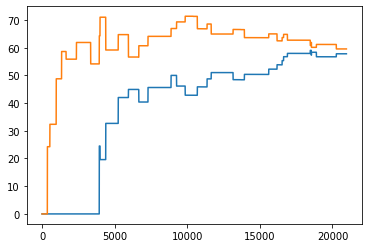

In [14]:
plt.plot([x for x,y in history])
plt.plot([y for x,y in history])
plt.show()

In [10]:
run()

MultiCanvas(layout=Layout(height='194px', width='194px'), size=(194, 194))